In [1]:
import random
import numpy.random as rnd

from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle
import json

from scipy.integrate import odeint
import scipy.special as sps
import scipy.optimize as spo
from scipy.integrate import odeint
#import interp1d
from scipy.interpolate import interp1d


from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')


plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['axes.labelsize']=25
plt.rcParams['legend.fontsize']= 20
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [2]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)

In [3]:
import analysis.mathematical_functions.funcs as funcs

In [4]:
class Simulation():
    def __init__(self, s, U, N,dt, step_appearance):
        self.s = s
        self.U = U
        self.N = N
        self.t = 0
        self.step_appearance = step_appearance
        self.t_end = 2*np.log(N*s)/s
        self.expected_max_mutants = int(3 * U * np.log(N*s) * N/ s)
        self.dt = dt
        self.N_t_steps = int(self.t_end/self.dt) + 2* step_appearance
    
    def initial_state(self):
        
        A_class = np.zeros((self.expected_max_mutants))
        B_class = np.zeros((self.expected_max_mutants))

        A_class[0] = self.N - 0
        B_class[0] = 0
        max_mut_A = 1
        max_mut_B = 1
        return A_class, B_class, max_mut_A, max_mut_B
    
    def timestep(self,A_class, B_class, max_mut_A, max_mut_B,step):

        N_A = np.sum(A_class)
        N_B = np.sum(B_class) ## b is the fitter one

        avg_f = (N_A + N_B*(1+self.s))/(N_A + N_B)

        f_A = 1
        f_B = 1 + self.s

        nonzero_A = np.where(A_class > 0)[0]
        nonzero_B = np.where(B_class > 0)[0]

        A_nonzero = A_class[nonzero_A]
        B_nonzero = B_class[nonzero_B]

        births_A = rnd.poisson( A_nonzero*f_A*self.dt)
        births_B = rnd.poisson( B_nonzero*f_B*self.dt)

        deaths_A = rnd.poisson( A_nonzero*avg_f*self.dt)
        deaths_B = rnd.poisson( B_nonzero*avg_f*self.dt)

        muts_A = rnd.poisson(N_A*self.U*self.dt)
        muts_B = rnd.poisson(N_B*self.U*self.dt)
        A_class[nonzero_A] += births_A - deaths_A
        B_class[nonzero_B] += births_B - deaths_B

        A_class = np.maximum(A_class,0)
        B_class = np.maximum(B_class,0)

        A_class[max_mut_A:max_mut_A+muts_A] = 1
        B_class[max_mut_B:max_mut_B+muts_B] = 1

        A_class[0]-=muts_A
        B_class[0]-=muts_B

        max_mut_A += muts_A
        max_mut_B += muts_B

        return A_class, B_class, max_mut_A, max_mut_B
    
    def run(self):
        A_class, B_class, max_mut_A, max_mut_B = self.initial_state()
        As = np.zeros((self.N_t_steps, self.expected_max_mutants))
        Bs = np.zeros((self.N_t_steps, self.expected_max_mutants))
        for i in range(self.N_t_steps):
            As[i] = A_class
            Bs[i] = B_class
            if np.sum(B_class) == 0 and i>self.step_appearance:
                print(f'B is extinct at timestep {i} out of {self.N_t_steps}')
                break
            # if np.sum(A_class) == 0:
            #     print(f'A is extinct at timestep {i} out of {self.N_t_steps}')
            #     break
            if i==self.step_appearance:
                A_class[0]-=10
                B_class[0]+=10
            A_class, B_class, max_mut_A, max_mut_B = self.timestep(A_class, B_class, max_mut_A, max_mut_B,step=i)

        return As, Bs

class sweepless_Simulation():
    def __init__(self, s, U, N,dt, step_appearance):
        self.s = s
        self.U = U
        self.N = N
        self.t = 0
        self.step_appearance = step_appearance
        self.t_end = 2*np.log(N*s)/s
        self.expected_max_mutants = int(4 * U * np.log(N*s) * N/ s)
        self.dt = dt
        self.N_t_steps = int(self.t_end/self.dt) + 2* step_appearance
    
    def initial_state(self):
        
        A_class = np.zeros((self.expected_max_mutants))
        A_class[0] = self.N
        max_mut_A = 1
        return A_class, max_mut_A
    
    def timestep(self,A_class, max_mut_A,step):  
        N_A = np.sum(A_class)
        avg_f = 1

        f_A = 1

        nonzero_A = np.where(A_class > 0)[0]
        A_nonzero = A_class[nonzero_A]
        births_A = rnd.poisson( A_nonzero*f_A*self.dt)
        deaths_A = rnd.poisson( A_nonzero*avg_f*self.dt)
        muts_A = rnd.poisson(N_A*self.U*self.dt)
        A_class[nonzero_A] += births_A - deaths_A
        A_class = np.maximum(A_class,0)

        A_class[max_mut_A:max_mut_A+muts_A] = 1
        A_class[0]-=muts_A
        max_mut_A += muts_A

        return A_class, max_mut_A
    
    def run(self):
        A_class, max_mut_A = self.initial_state()
        As = np.zeros((self.N_t_steps, self.expected_max_mutants))
        for i in range(self.N_t_steps):
            As[i] = A_class
            if np.sum(A_class) == 0:
                print(f'A is extinct at timestep {i} out of {self.N_t_steps}')
                break
            A_class, max_mut_A = self.timestep(A_class, max_mut_A,step=i)
        return As
        


In [5]:
N = 1e7
U = 5e-5
s = 0.1
dt= 5e-2

B= 0


while np.max(B)<100:
    sim = Simulation(s, U, N, dt, step_appearance=2000)
    A, B = sim.run()




B is extinct at timestep 2074 out of 9526


In [6]:
sweepless_sim = sweepless_Simulation(s, U, N, dt, step_appearance=2000)
A_sweepless = sweepless_sim.run()

In [7]:
sweepless_sim

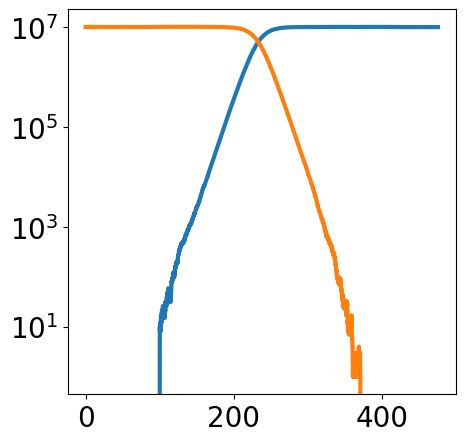

In [8]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
N_As = np.sum(A,axis=1)
N_Bs = np.sum(B,axis=1)
ts = np.arange(0, sim.N_t_steps)*sim.dt
ax.plot(ts,N_Bs, label='A')
ax.plot(ts,N_As, label='A')
ax.set_yscale('log')

In [9]:

tb_A_hist_list= {}
tb_B_hist_list = {}
tot_ts_hist_list = {}

python(4175) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


counts: 116679, 120215


 33%|███▎      | 1/3 [00:18<00:37, 18.53s/it]

counts: 888, 1095


 67%|██████▋   | 2/3 [00:35<00:17, 17.45s/it]

counts: 183, 319


100%|██████████| 3/3 [00:51<00:00, 17.32s/it]

counts: 33, 103


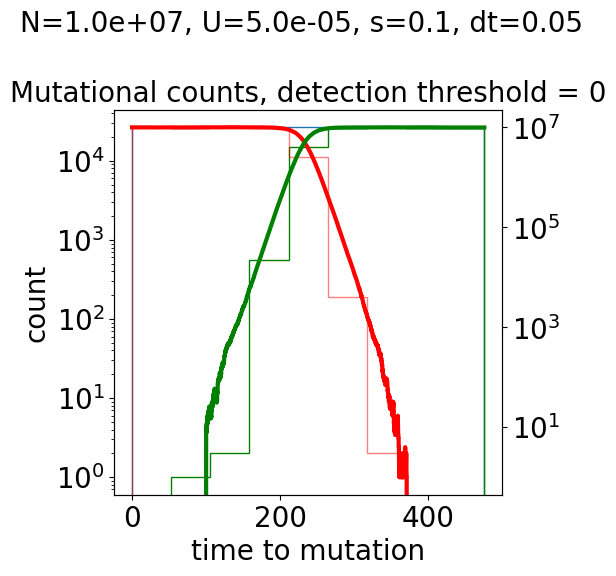

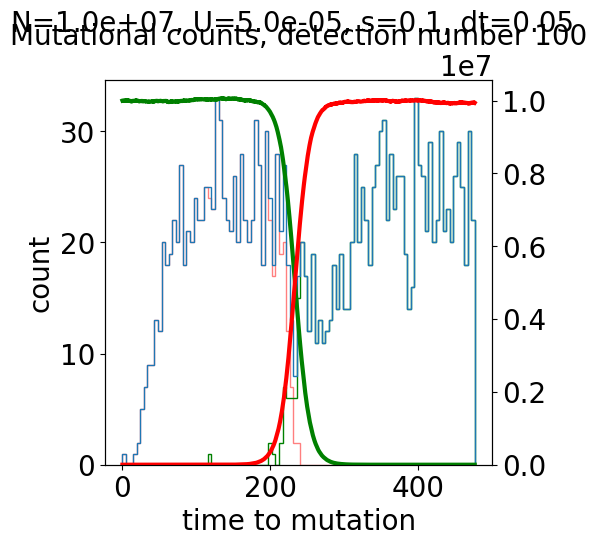

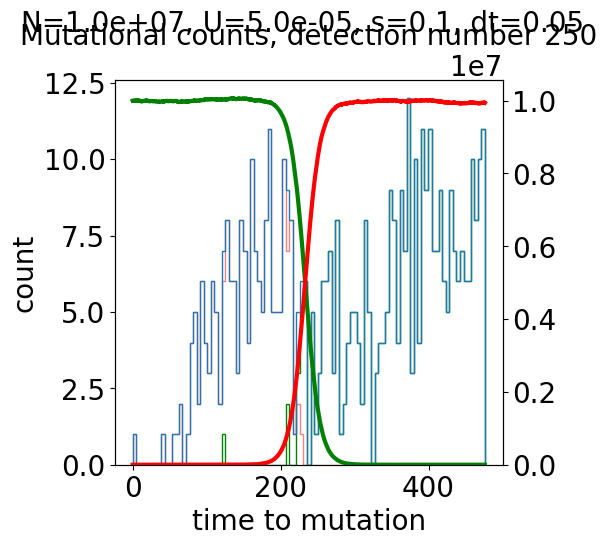

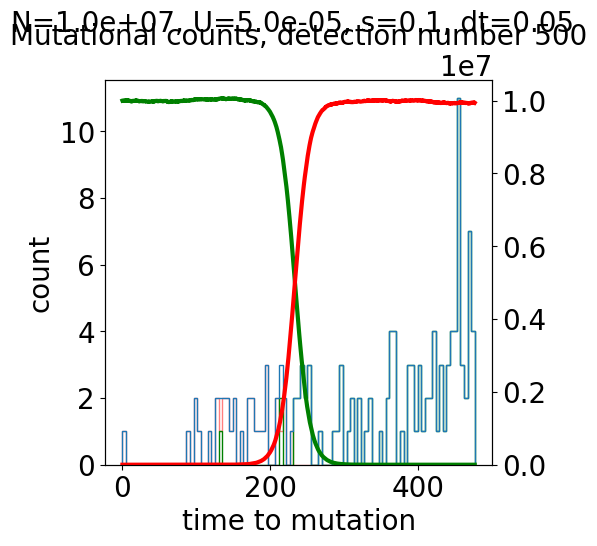

In [12]:
tb_A = [ts[A[:,i]>0][0] for i in range(A.shape[1]) if np.sum(A[:,i])>0]
tb_B = [ts[B[:,i]>0][0] for i in range(B.shape[1]) if np.sum(B[:,i])>0]

tot_ts=  np.concatenate([tb_A,tb_B])

bins = np.linspace(0, ts[-1], 10)
fig,ax = plt.subplots(1,1,figsize=(5,5))
tot_ts_hist_list[0] = ax.hist(tot_ts, bins=bins,histtype='step')
tb_B_hist_list [0] = ax.hist(tb_B, bins=bins,color='green',histtype='step')
tb_A_hist_list[0] = ax.hist(tb_A, bins=bins,color='red', alpha=0.5,histtype='step')

fig.suptitle(f'N={N:.1e}, U={U:.1e}, s={s}, dt={dt}',fontsize=20, y=1.08)
ax.set_xlabel('time to mutation',fontsize=20)
ax.set_ylabel('count',fontsize=20)
ax.set_title('Mutational counts, detection threshold = 0',fontsize=20)
tax = ax.twinx()
tax.plot(ts, N_As, color='red')
tax.plot(ts, N_Bs, color='green')
# tax.set_ylim(bottom=-1)
tax.set_yscale('log')
print(f'counts: {len(tb_A)}, {len(tb_B)}')
ax.set_yscale('log')

for detection_n in tqdm([100,250,500]):

    tb_A = [ts[A[:,i]>=detection_n][0] for i in range(A.shape[1]) if np.max(A[:,i])>=detection_n]
    tb_B = [ts[B[:,i]>=detection_n][0] for i in range(B.shape[1]) if np.max(B[:,i])>=detection_n]

    tot_ts=  np.concatenate([tb_A,tb_B])

    bins = np.linspace(0, ts[-1], 100)
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    tb_A_hist_list[detection_n] = ax.hist(tb_A, bins=bins,color='red', alpha=0.5,histtype='step')
    tb_B_hist_list [detection_n] = ax.hist(tb_B, bins=bins,color='green',histtype='step')
    tot_ts_hist_list[detection_n] = ax.hist(tot_ts, bins=bins,histtype='step')
    tax = ax.twinx()
    tax.plot(ts, N_As, color='green')
    tax.plot(ts, N_Bs, color='red')
    tax.set_ylim(bottom=-1)
    fig.suptitle(f'N={N:.1e}, U={U:.1e}, s={s}, dt={dt}',fontsize=20, y=1.02)
    ax.set_xlabel('time to mutation',fontsize=20)
    ax.set_ylabel('count',fontsize=20)
    ax.set_title(f'Mutational counts, detection number {detection_n}',fontsize=20)

    print(f'counts: {len(tb_A)}, {len(tb_B)}')

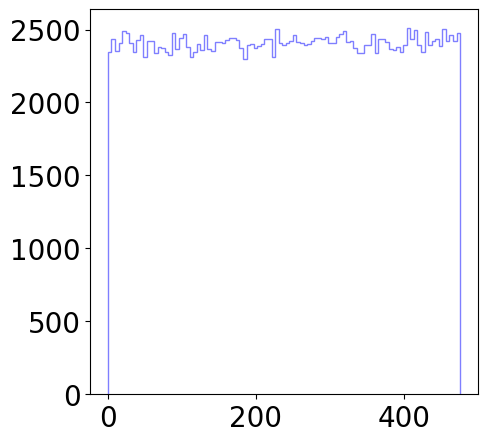

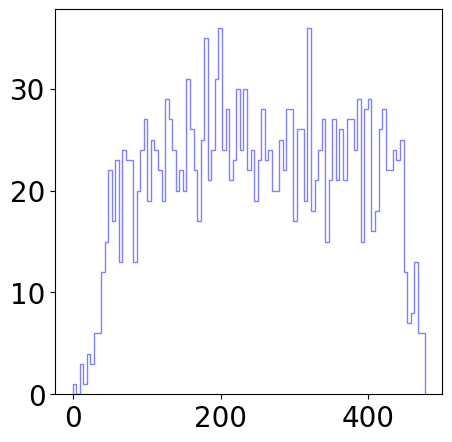

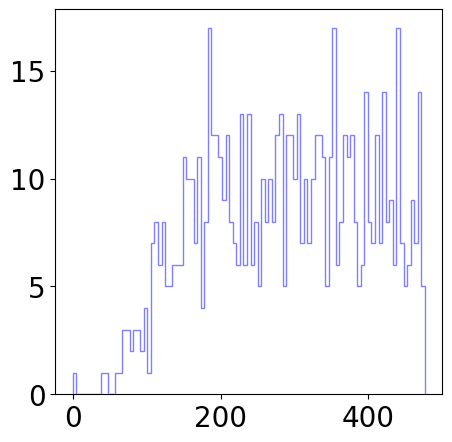

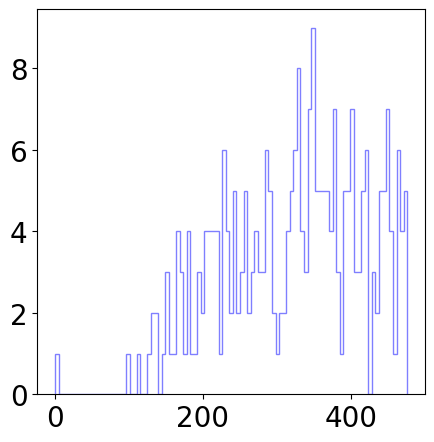

In [14]:
tb_A_sweepless_hist_list= {}
fig,ax= plt.subplots(1,1,figsize=(5,5))
tb_A_sweepless = [ts[A_sweepless[:,i]>0][0] for i in range(A_sweepless.shape[1]) if np.sum(A_sweepless[:,i])>0]
tb_A_sweepless_hist_list[0] = ax.hist(tb_A_sweepless, bins=bins,color='blue', alpha=0.5,histtype='step')
for detection_n in [100,250,500]:
    tb_A_sweepless = [ts[A_sweepless[:,i]>=detection_n][0] for i in range(A.shape[1]) if np.max(A_sweepless[:,i])>=detection_n]
    bins = np.linspace(0, ts[-1], 100)
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    tb_A_sweepless_hist_list[detection_n] = ax.hist(tb_A_sweepless, bins=bins,color='blue', alpha=0.5,histtype='step')

In [ ]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

counts: 43, 80
counts: 43, 80
counts: 43, 80
counts: 43, 80


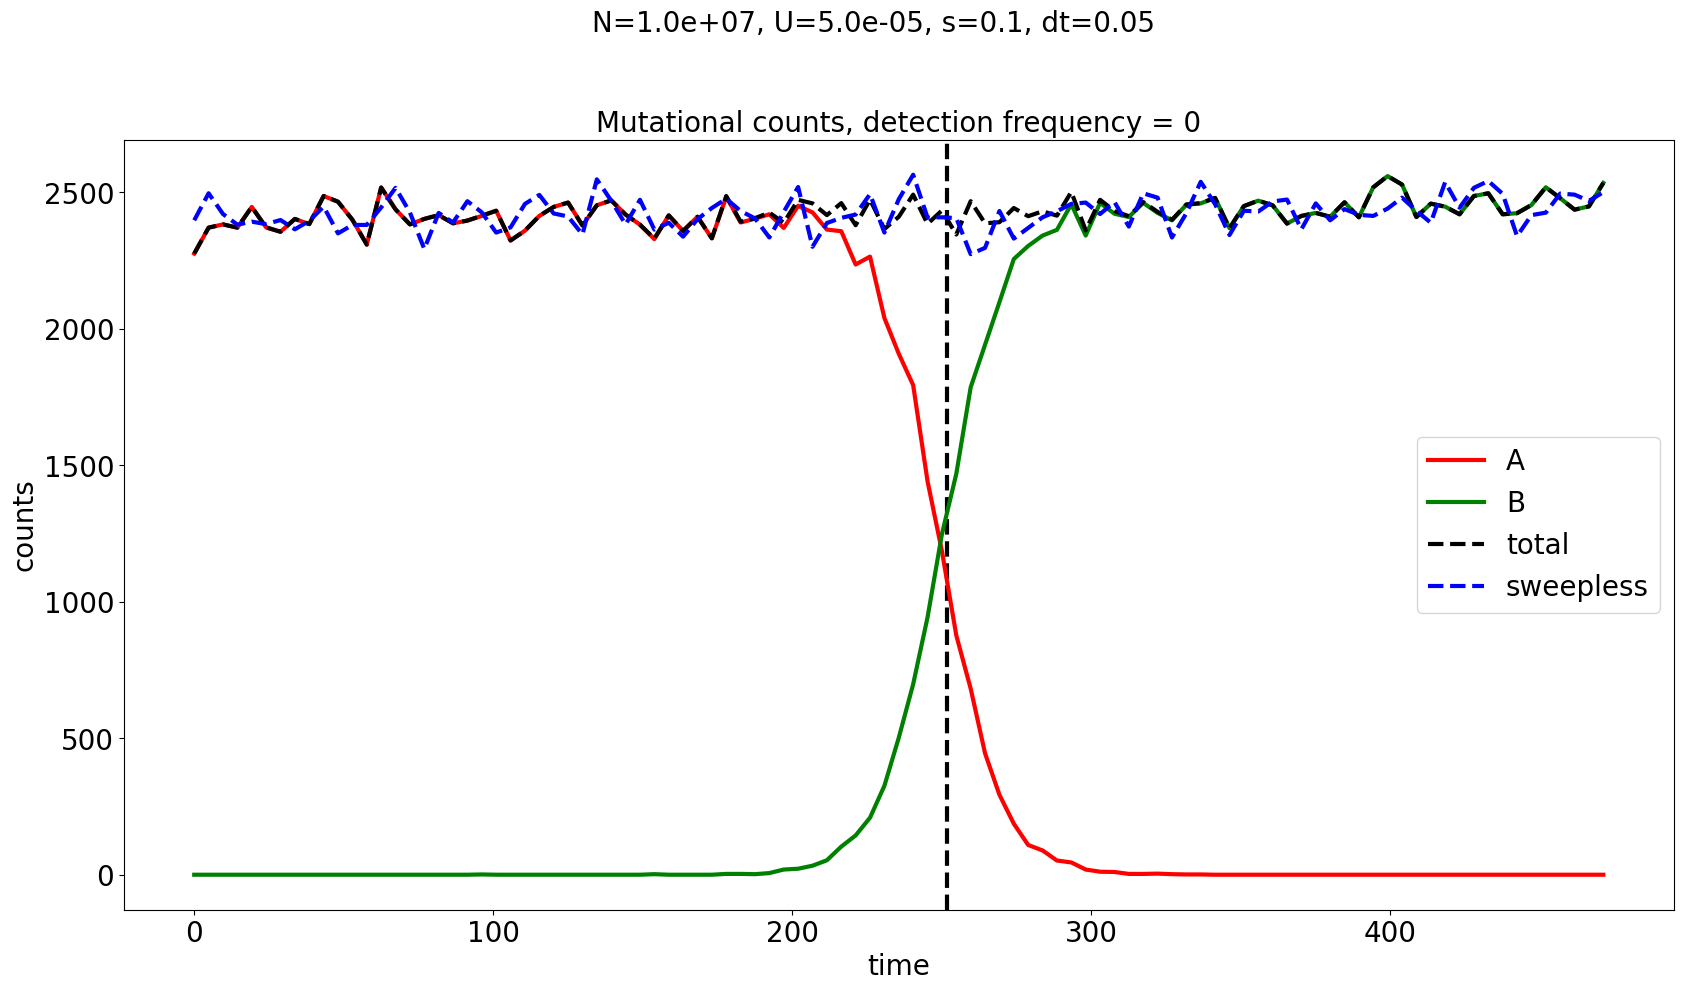

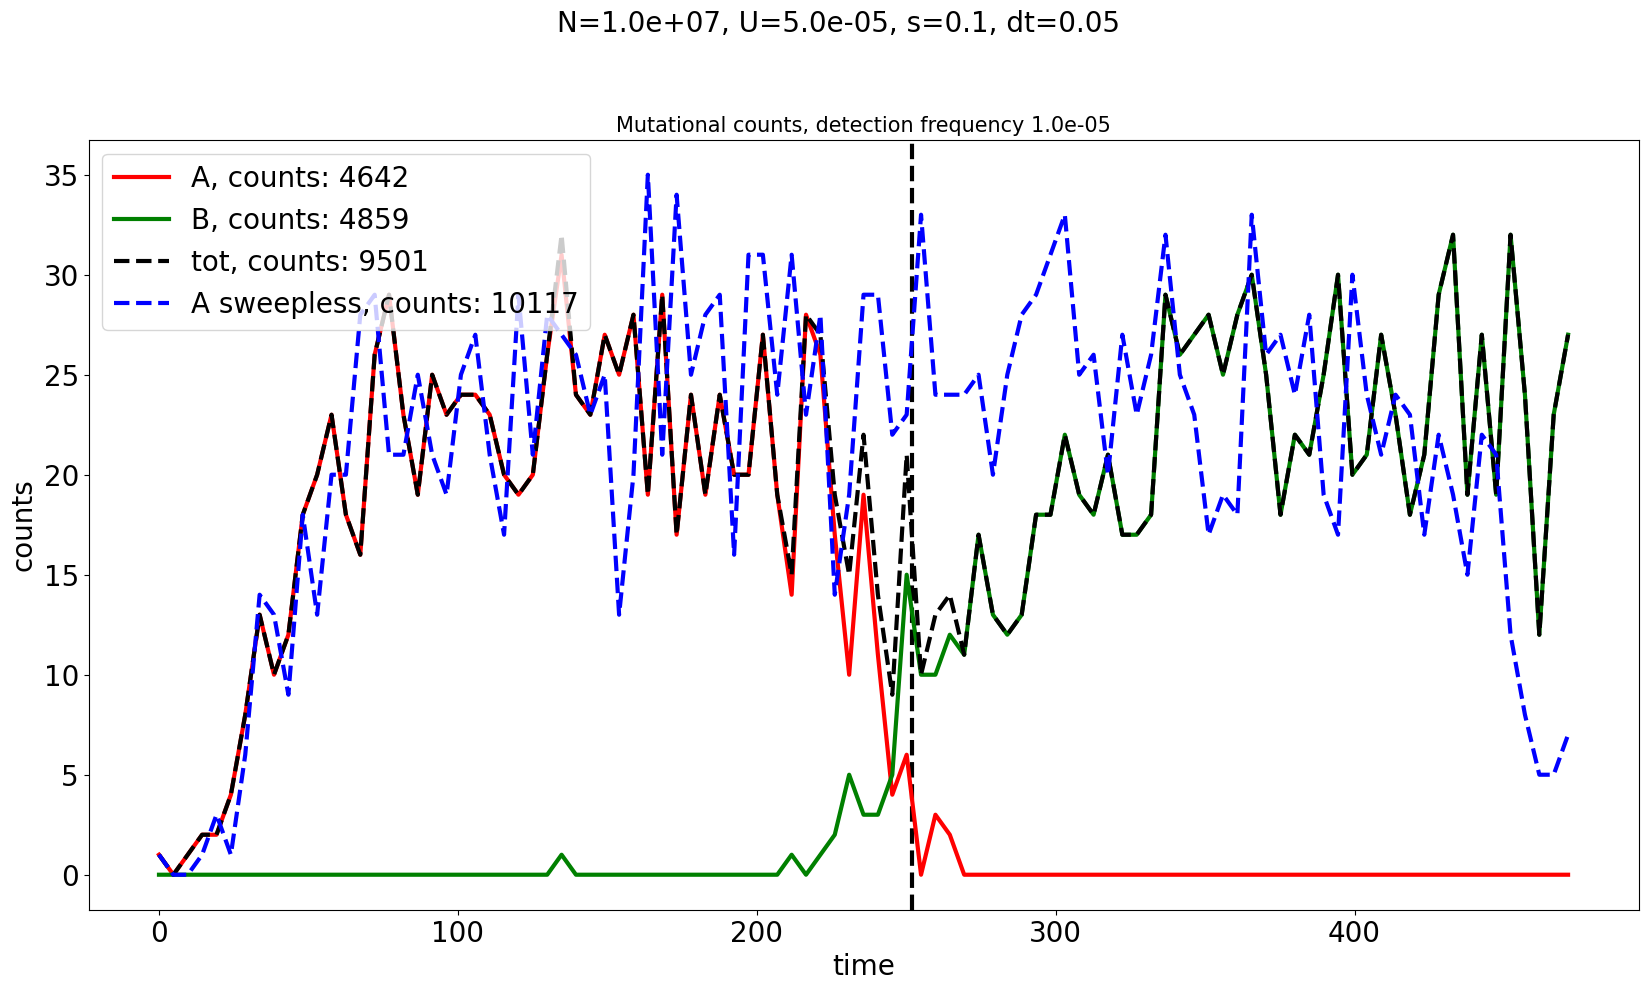

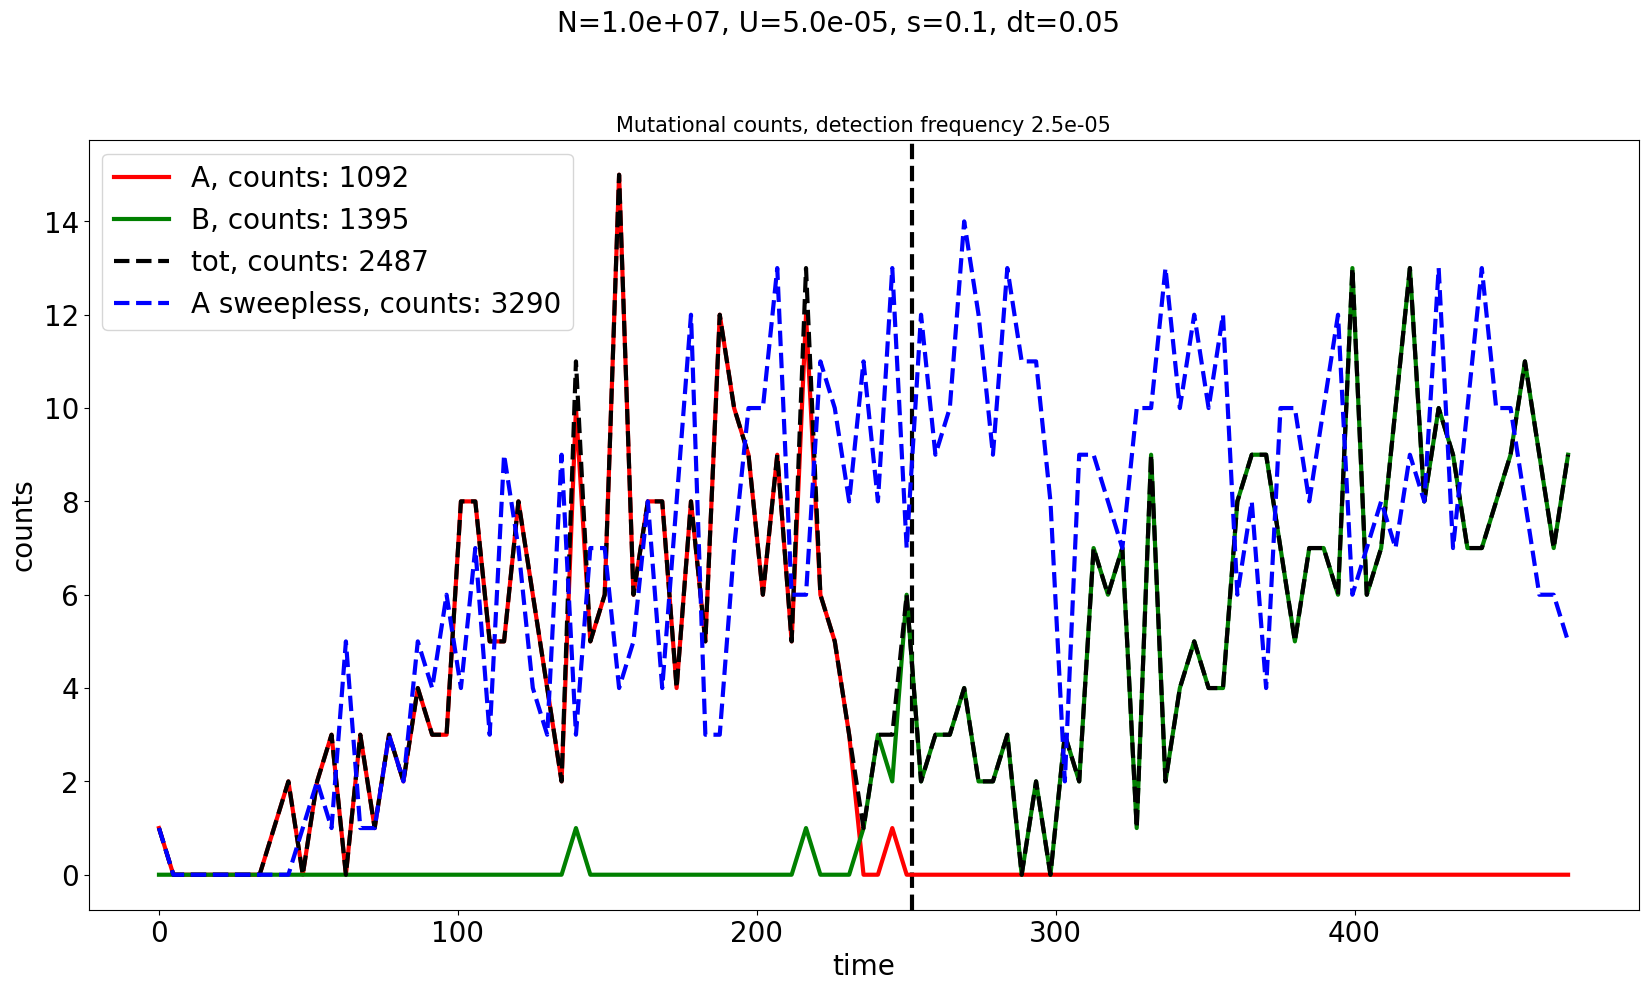

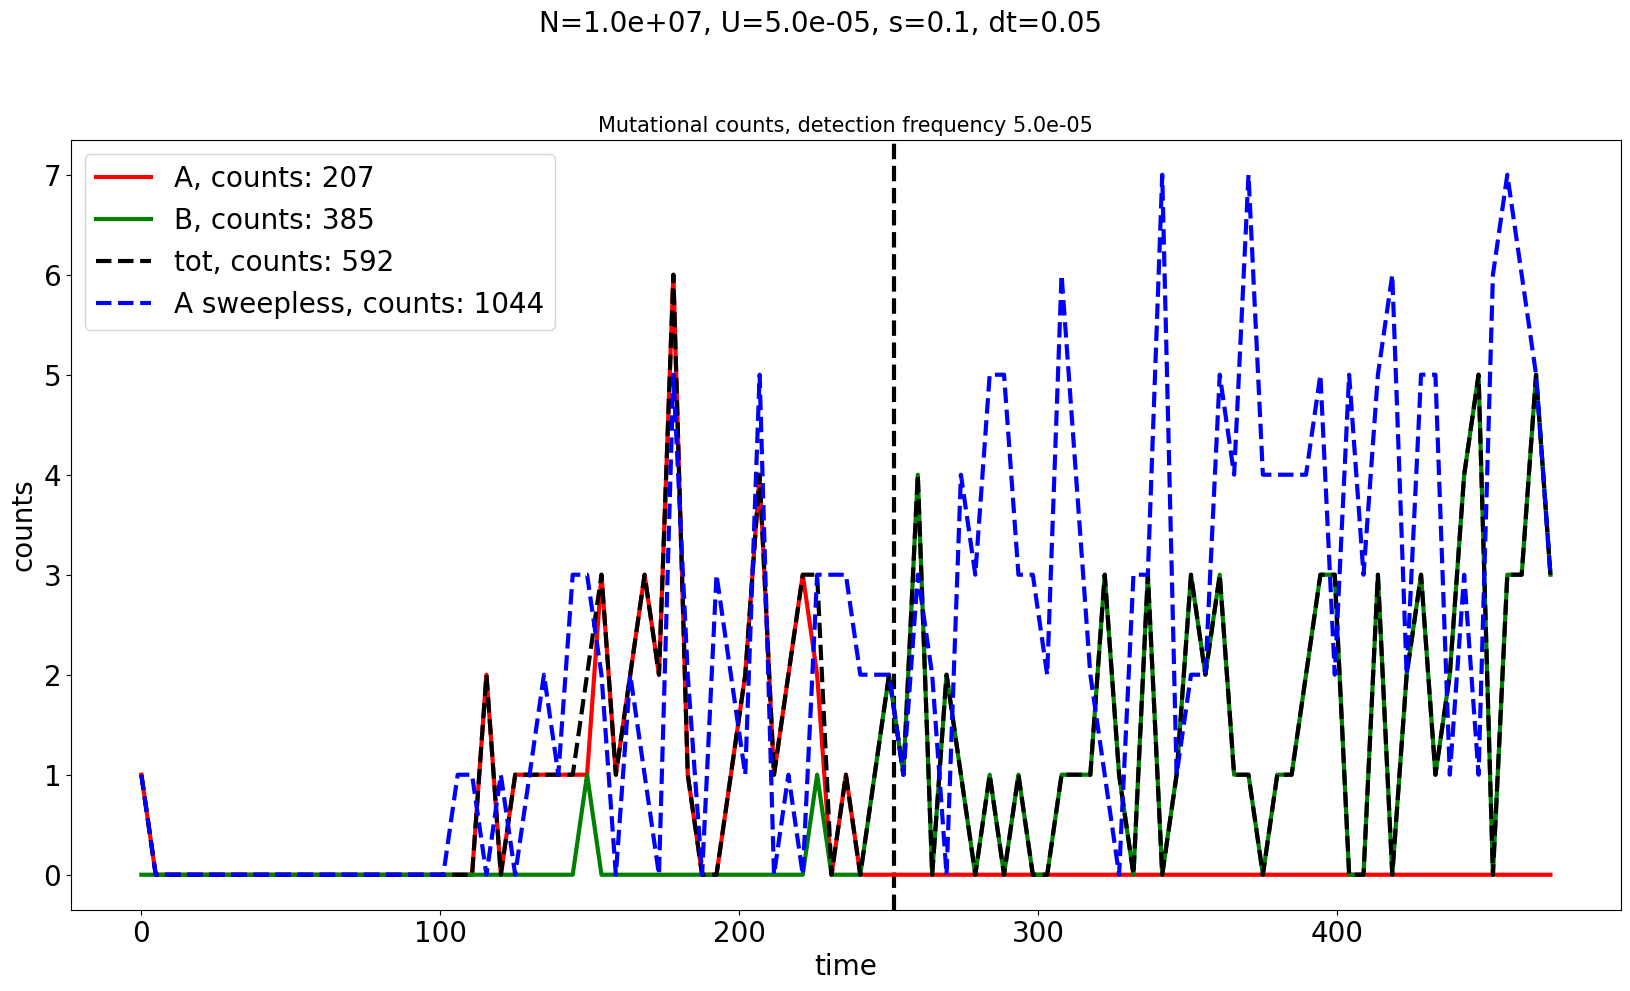

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
h_A,b_A,p_A = tb_A_hist_list[0] 
h_B,b_B,p_B = tb_B_hist_list [0] 
h_tot,b_tot,p_tot = tot_ts_hist_list[0] 
h_A_sweepless, b_A_sweepless, p_A_sweepless = tb_A_sweepless_hist_list[0]

ind_crossover = np.where(N_As<N_Bs)[0][0]
ax.axvline(ts[ind_crossover],color='black',ls='--')
ax.plot(b_tot[:-1],h_A, color='red',label='A')
ax.plot(b_tot[:-1],h_B, color='green',label='B')
ax.plot(b_tot[:-1],h_tot, color='black',label='total',ls= '--')
ax.plot(b_A_sweepless[:-1],h_A_sweepless, label='sweepless',color='blue',ls= '--')

fig.suptitle(f'N={N:.1e}, U={U:.1e}, s={s}, dt={dt}',fontsize=20, y=1.01)
ax.set_xlabel('time',fontsize=20)
ax.set_ylabel('counts',fontsize=20)
ax.set_title('Mutational counts, detection frequency = 0',fontsize=20)
# tax = ax.twinx()
# tax.plot(ts, N_As, color='green')
# tax.plot(ts, N_Bs, color='red')
ax.legend(loc='best',fontsize=20)
# tax.set_ylim(bottom=-1)
# tax.set_yscale('log')
print(f'counts: {len(tb_A)}, {len(tb_B)}')
# ax.set_yscale('log')

plt.savefig(output_folder+f'N_{N:.1e}_U_{U:.1e}_s_{s}_dt_{dt}_detection_0_proc1.pdf',bbox_inches= 'tight')

for detection_n in [100,250,500]:
    fig,ax = plt.subplots(1,1,figsize=(20,10))

    h_A,b_A,p_A = tb_A_hist_list[detection_n] 
    h_B,b_B,p_B = tb_B_hist_list [detection_n] 
    h_tot,b_tot,p_tot = tot_ts_hist_list[detection_n] 

    h_A_sweepless, b_A_sweepless, p_A_sweepless = tb_A_sweepless_hist_list[detection_n]

    ax.axvline(ts[ind_crossover],color='black',ls='--')
    
    ax.plot(b_tot[:-1],h_A, color='red', label = f'A, counts: {np.sum(h_A*np.diff(b_A)):.0f}')
    ax.plot(b_tot[:-1],h_B, color='green', label = f'B, counts: {np.sum(h_B*np.diff(b_B)):.0f}')
    ax.plot(b_tot[:-1],h_tot, color='black',ls= '--', label = f'tot, counts: {np.sum(h_tot*np.diff(b_tot)):.0f}')
    ax.plot(b_A_sweepless[:-1],h_A_sweepless, color='blue',ls= '--', label = f'A sweepless, counts: {np.sum(h_A_sweepless*np.diff(b_A_sweepless)):.0f}')

    # tax = ax.twinx()
    # tax.plot(ts, N_As, color='green')
    # tax.plot(ts, N_Bs, color='red')
    # tax.set_ylim(bottom=-1)
    fig.suptitle(f'N={N:.1e}, U={U:.1e}, s={s}, dt={dt}',fontsize=20, y=1.01)
    ax.set_xlabel('time',fontsize=20)
    ax.set_ylabel('counts',fontsize=20)
    ax.set_title(f'Mutational counts, detection frequency {detection_n/N:.1e}',fontsize=15)
    ax.legend(loc='best',fontsize=20)
    print(f'counts: {len(tb_A)}, {len(tb_B)}')
    plt.savefig(output_folder+f'N_{N:.1e}_U_{U:.1e}_s_{s}_dt_{dt}_detection_{detection_n}_proc1.pdf',bbox_inches= 'tight')

In [15]:
from scipy.ndimage import gaussian_filter1d

counts: 33, 103
counts: 33, 103
counts: 33, 103
counts: 33, 103


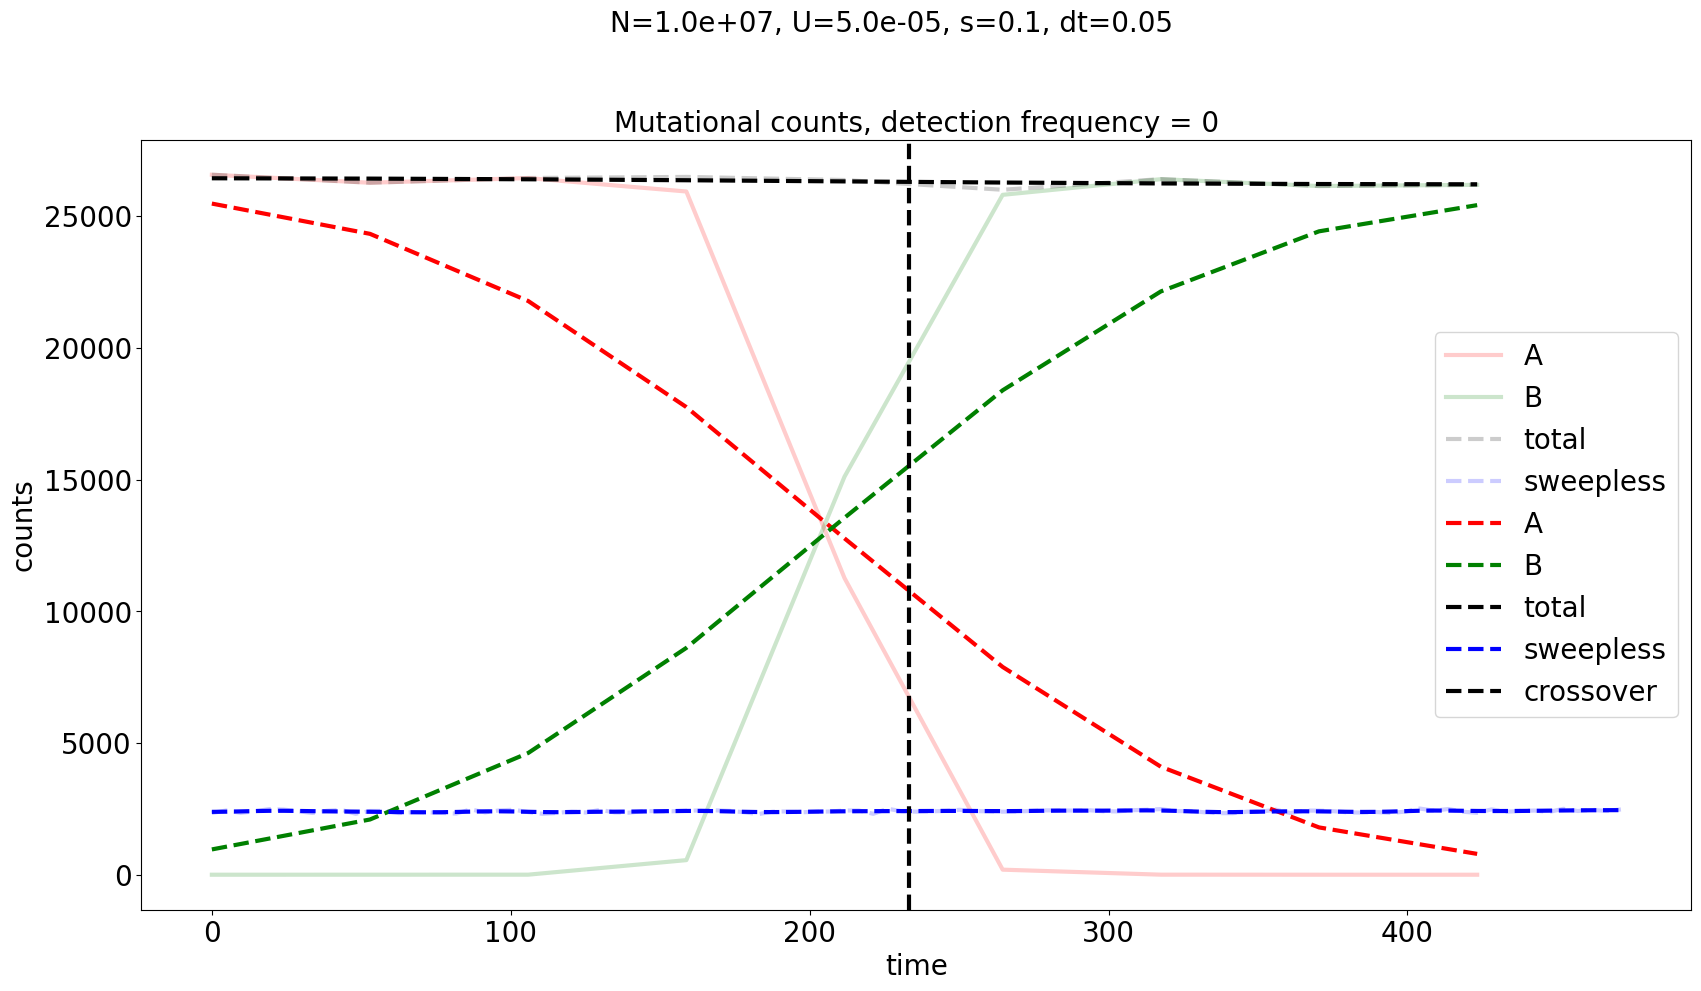

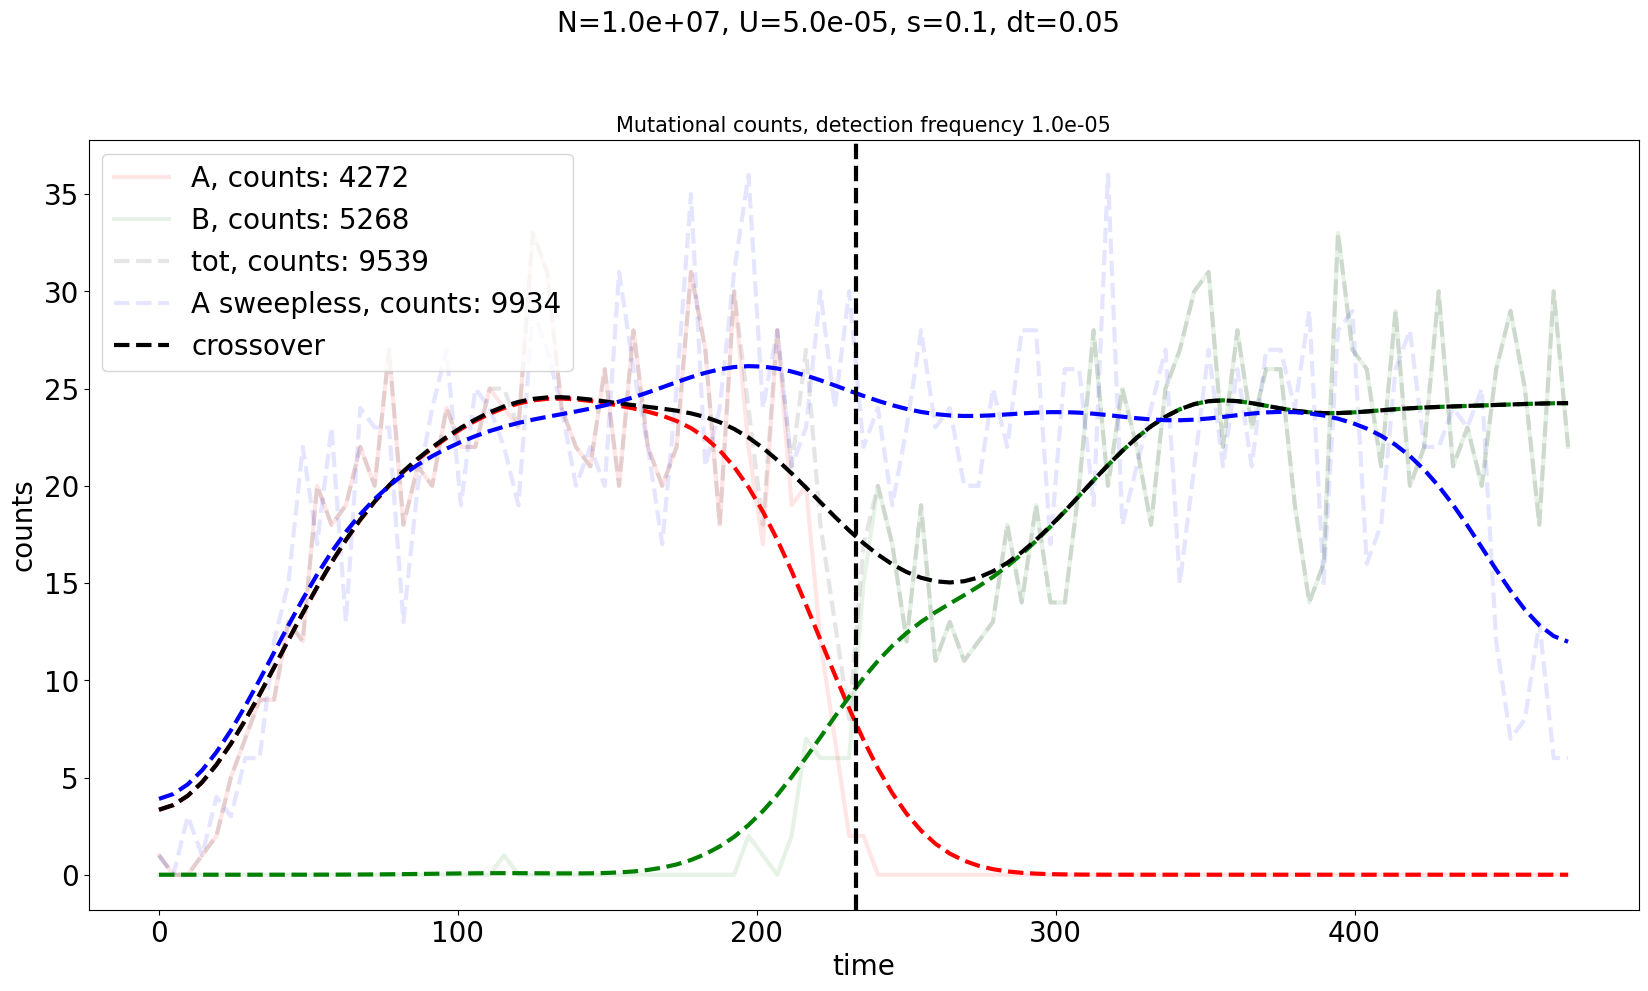

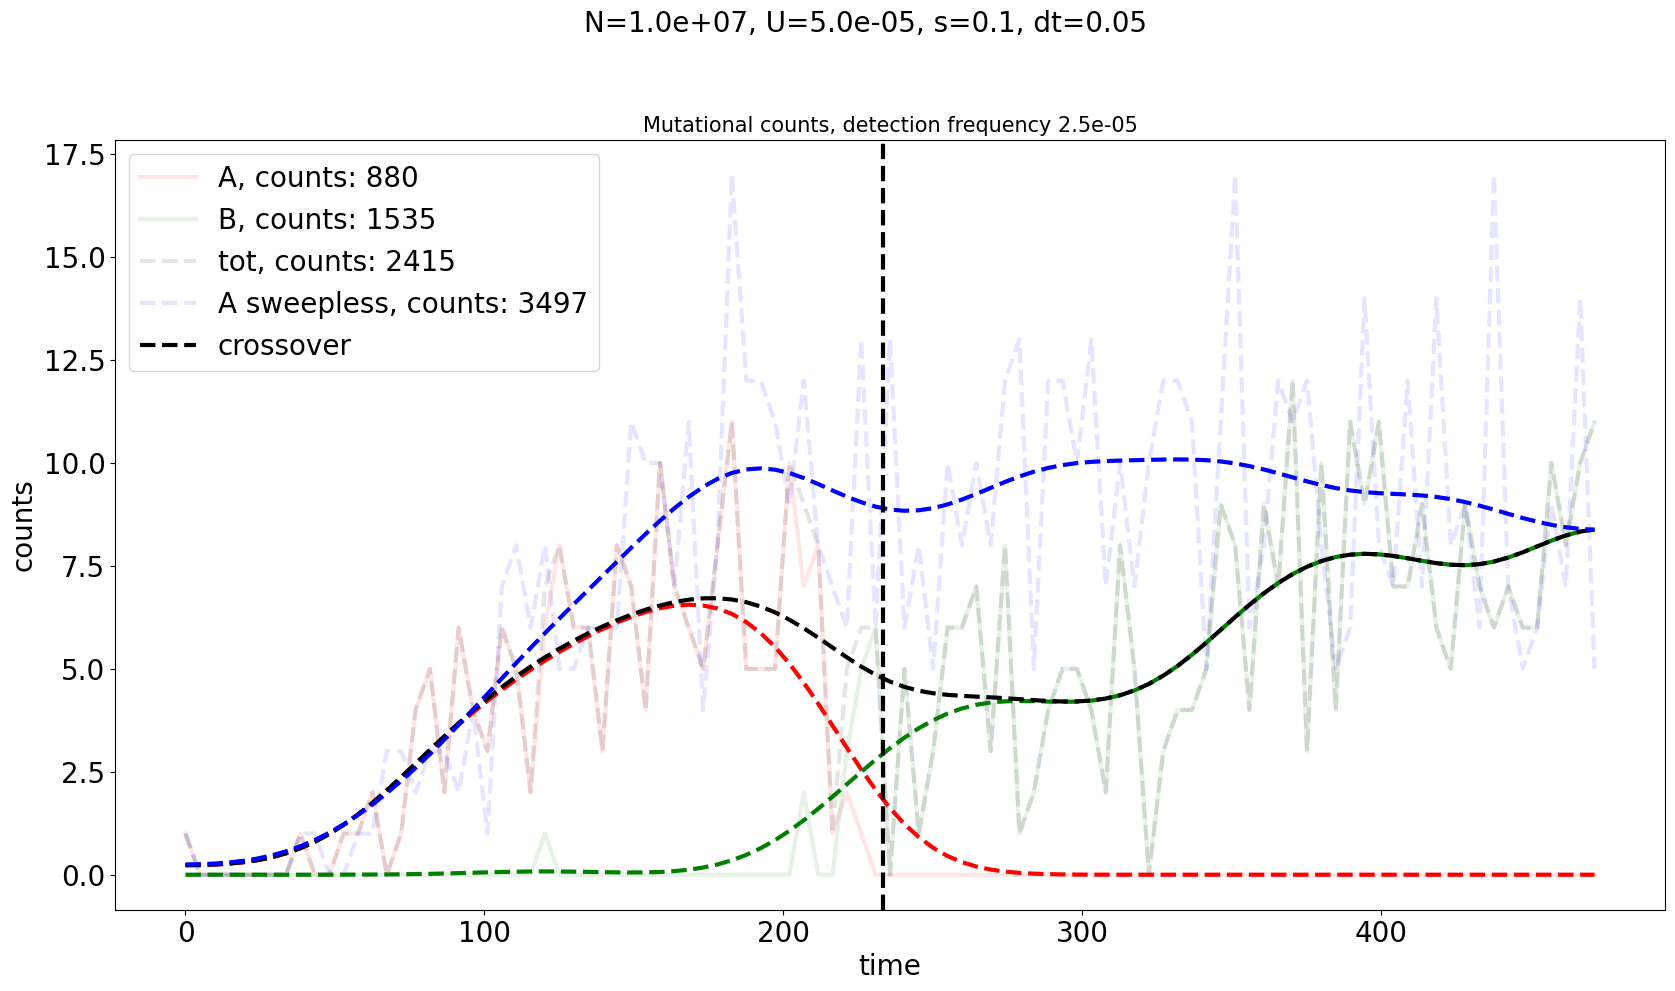

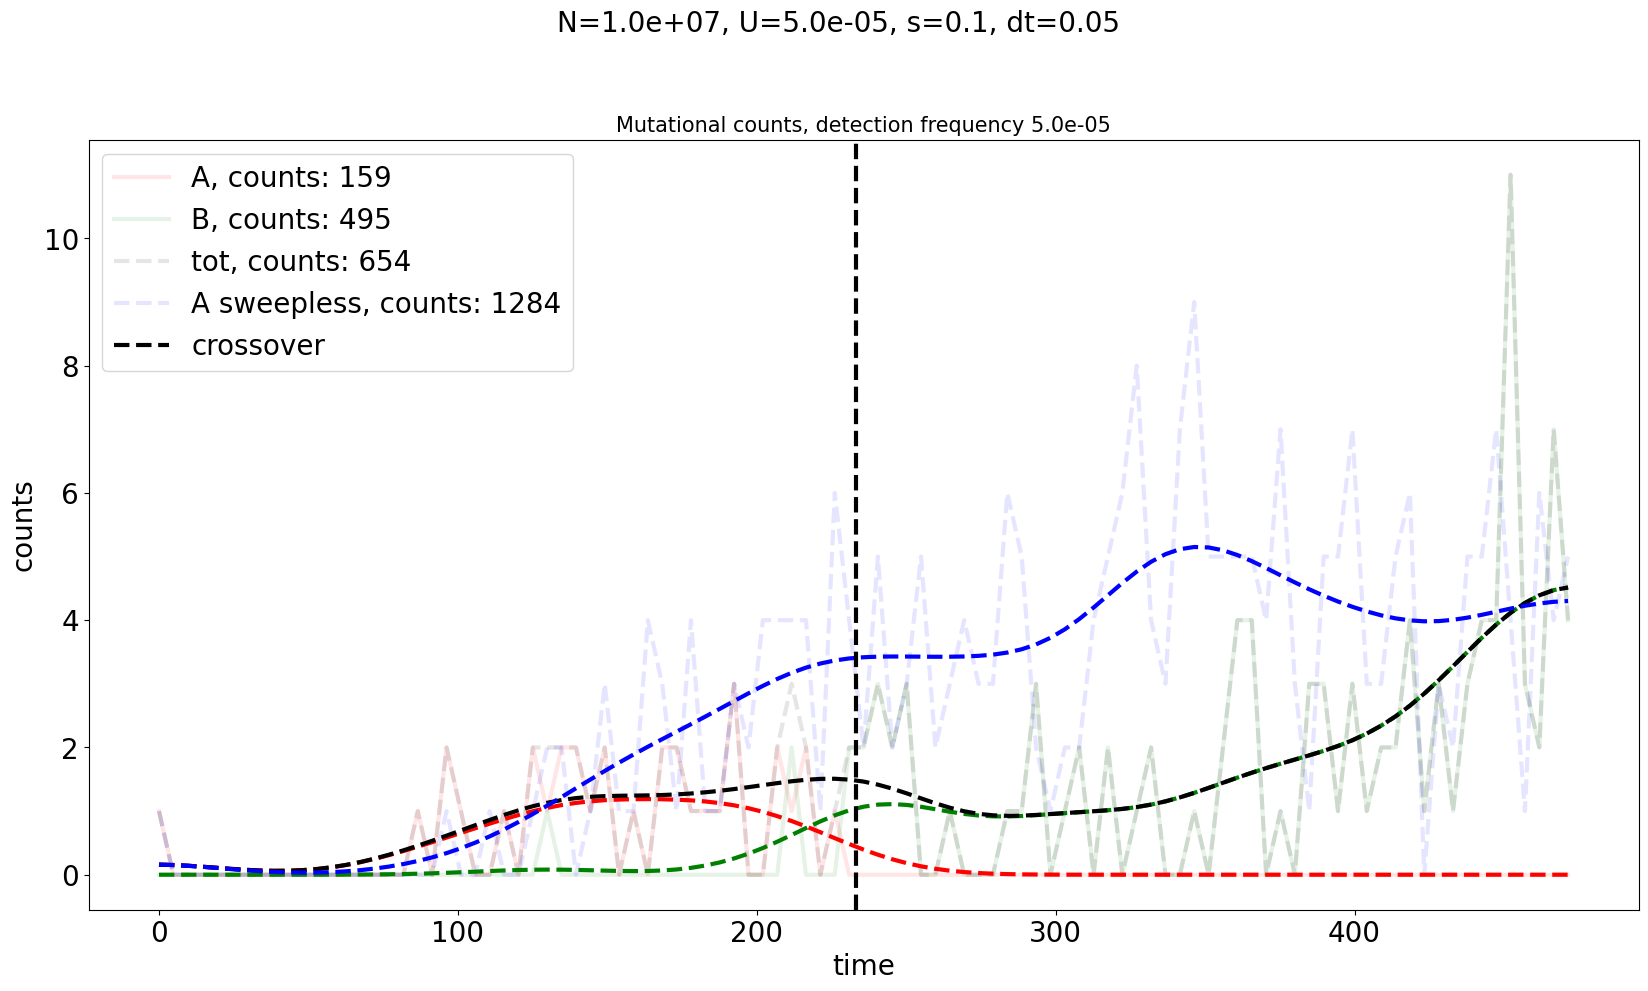

In [17]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
h_A,b_A,p_A = tb_A_hist_list[0] 
h_B,b_B,p_B = tb_B_hist_list [0] 
h_tot,b_tot,p_tot = tot_ts_hist_list[0] 
h_A_sweepless, b_A_sweepless, p_A_sweepless = tb_A_sweepless_hist_list[0]

h_A_smooth = gaussian_filter1d(h_A, sigma=2)
h_B_smooth = gaussian_filter1d(h_B, sigma=2)
h_tot_smooth = gaussian_filter1d(h_tot, sigma=2)
h_A_sweepless_smooth = gaussian_filter1d(h_A_sweepless, sigma=2)

ax.plot(b_tot[:-1],h_A, color='red',label='A',alpha=.2)
ax.plot(b_tot[:-1],h_B, color='green',label='B',alpha=.2)
ax.plot(b_tot[:-1],h_tot, color='black',label='total',ls= '--',alpha=.2)
ax.plot(b_A_sweepless[:-1],h_A_sweepless, label='sweepless',color='blue',ls= '--',alpha=.2)

ax.plot(b_tot[:-1],h_A_smooth, color='red',label='A',ls='--')
ax.plot(b_tot[:-1],h_B_smooth, color='green',label='B',ls='--')
ax.plot(b_tot[:-1],h_tot_smooth, color='black',label='total',ls= '--')
ax.plot(b_A_sweepless[:-1],h_A_sweepless_smooth, label='sweepless',color='blue',ls= '--')

crossover_ind = np.where(N_Bs>N_As)[0][0]
ax.axvline(ts[crossover_ind],color='black',ls='--',label='crossover')
fig.suptitle(f'N={N:.1e}, U={U:.1e}, s={s}, dt={dt}',fontsize=20, y=1.01)
ax.set_xlabel('time',fontsize=20)
ax.set_ylabel('counts',fontsize=20)
ax.set_title('Mutational counts, detection frequency = 0',fontsize=20)
# tax = ax.twinx()
# tax.plot(ts, N_As, color='green')
# tax.plot(ts, N_Bs, color='red')
ax.legend(loc='best',fontsize=20)
# tax.set_ylim(bottom=-1)
# tax.set_yscale('log')
print(f'counts: {len(tb_A)}, {len(tb_B)}')
# ax.set_yscale('log')

# plt.savefig(output_folder+f'N_{N:.1e}_U_{U:.1e}_s_{s}_dt_{dt}_detection_0.pdf',bbox_inches='tight')

for detection_n in [100,250,500]:
    fig,ax = plt.subplots(1,1,figsize=(20,10))

    h_A,b_A,p_A = tb_A_hist_list[detection_n] 
    h_B,b_B,p_B = tb_B_hist_list [detection_n] 
    h_tot,b_tot,p_tot = tot_ts_hist_list[detection_n] 
    h_A_sweepless, b_A_sweepless, p_A_sweepless = tb_A_sweepless_hist_list[detection_n]

    h_A_smooth = gaussian_filter1d(h_A, sigma=5)
    h_B_smooth = gaussian_filter1d(h_B, sigma=5)
    h_tot_smooth = gaussian_filter1d(h_tot, sigma=5)
    h_A_sweepless_smooth = gaussian_filter1d(h_A_sweepless, sigma=5)

    ax.plot(b_tot[:-1],h_A, color='red', label = f'A, counts: {np.sum(h_A*np.diff(b_A)):.0f}', alpha=.1)
    ax.plot(b_tot[:-1],h_B, color='green', label = f'B, counts: {np.sum(h_B*np.diff(b_B)):.0f}', alpha=.1)
    ax.plot(b_tot[:-1],h_tot, color='black',ls= '--', label = f'tot, counts: {np.sum(h_tot*np.diff(b_tot)):.0f}', alpha=.1)
    ax.plot(b_A_sweepless[:-1],h_A_sweepless, color='blue',ls= '--', label = f'A sweepless, counts: {np.sum(h_A_sweepless*np.diff(b_A_sweepless)):.0f}', alpha=.1)

    ax.plot(b_tot[:-1],h_A_smooth, color='red',ls='--')
    ax.plot(b_tot[:-1],h_B_smooth, color='green',ls='--')
    ax.plot(b_tot[:-1],h_tot_smooth, color='black',ls= '--')
    ax.plot(b_A_sweepless[:-1],h_A_sweepless_smooth, color='blue',ls= '--')



    ax.axvline(ts[crossover_ind],color='black',ls='--',label='crossover')
    # tax = ax.twinx()
    # tax.plot(ts, N_As, color='green')
    # tax.plot(ts, N_Bs, color='red')
    # tax.set_ylim(bottom=-1)
    fig.suptitle(f'N={N:.1e}, U={U:.1e}, s={s}, dt={dt}',fontsize=20, y=1.01)
    ax.set_xlabel('time',fontsize=20)
    ax.set_ylabel('counts',fontsize=20)
    ax.set_title(f'Mutational counts, detection frequency {detection_n/N:.1e}',fontsize=15)
    ax.legend(loc='best',fontsize=20)
    print(f'counts: {len(tb_A)}, {len(tb_B)}')
    # plt.savefig(output_folder+f'N_{N:.1e}_U_{U:.1e}_s_{s}_dt_{dt}_detection_{detection_n}.pdf',bbox_inches='tight')

In [ ]:
max_freqs_A = np.max(A,axis=0)/N
max_freqs_B = np.max(B,axis=0)/N
max_freqs_joint = np.concatenate([max_freqs_A,max_freqs_B])

max_freqs_A_sweepless = np.max(A_sweepless,axis=0)/N

Text(0, 0.5, 'inverse cumulative density')

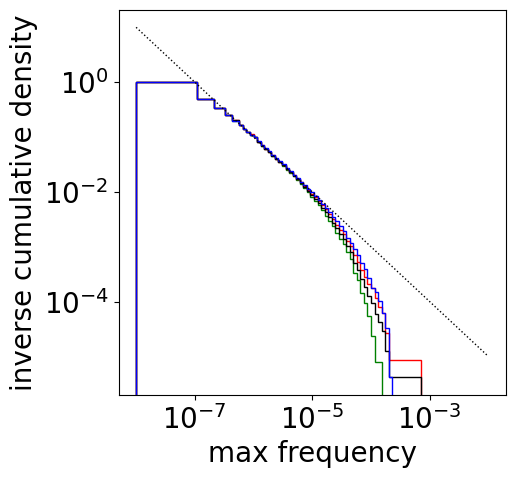

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.hist(max_freqs_A, bins=np.logspace(-np.log10(10*N),-2,100),histtype='step', cumulative=-1,density= 1,label = 'A', color='green');
ax.hist(max_freqs_B, bins=np.logspace(-np.log10(10*N),-2,100),histtype='step', cumulative=-1,density= 1,label = 'B', color='red');
ax.hist(max_freqs_joint, bins=np.logspace(-np.log10(10*N),-2,100),histtype='step', cumulative=-1,density= 1, color='black');
ax.hist(max_freqs_A_sweepless, bins=np.logspace(-np.log10(10*N),-2,100),histtype='step', cumulative=-1,density= 1, color='blue');

xs_plot = np.logspace(-np.log10(10*N),-2,100)
ax.plot(xs_plot, 10 * xs_plot[0]/xs_plot , label='theory', color='black',lw=1,ls=':')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('max frequency',fontsize=20)
ax.set_ylabel('inverse cumulative density',fontsize=20)